In [15]:
import pickle 
import numpy as np
import pandas as pd

with open("../data/processed/DREAMER_filtered.pkl", "rb") as f:
    df = pickle.load(f)

s0 = df.loc[0 , "stimuli"]
s1 = df.loc[0 , "baseline"]
print(type(s0))
print(s0.shape)
print(s1.shape)

<class 'numpy.ndarray'>
(25472, 14)
(7808, 14)


Stimuli shape: (25472, 14)
Baseline shape: (7808, 14)

>For the next steps we need to make the shapes identical 
>In 128Hz , Each 128 sample => 1 second


**Calculate RMS** 

RMS measures the overall signal power of each EEG channel.
By comparing stimulus vs baseline:

we see how much each channel's activity increased or decreased when the video started.

ΔRMS > 0 → higher activation / arousal

ΔRMS < 0 → reduced activation / suppression

This feature captures intensity of emotional and cognitive response per channel.

In [16]:
import numpy as np
import matplotlib.pyplot as plt

FS = 128 
BASELINE = df.loc[0, "baseline"]  
STIMULUS = df.loc[0, "stimuli"]   

# FIXED: Use full baseline and stimulus (no truncation)
# This properly compares the entire resting period vs entire video period
b = BASELINE - BASELINE.mean(axis=0, keepdims=True)
s = STIMULUS - STIMULUS.mean(axis=0, keepdims=True)

# RMS per channel (on full signals)
rms_b = np.sqrt(np.mean(b * b, axis=0))  
rms_s = np.sqrt(np.mean(s * s, axis=0))  

# Reactivity
reactivity = rms_s - rms_b
print("ΔRMS (14 channels):", reactivity)

# Visualization (optional - comment out if not needed)
# channels = [f"{i+1}" for i in range(b.shape[1])]
# x = np.arange(len(channels))        
# plt.bar(x, reactivity)
# plt.xticks(x, channels, rotation=45)
# plt.ylabel("ΔRMS")
# plt.title("EEG Channel Reactivity (Stimulus - Baseline)")
# plt.tight_layout()
# plt.show()


ΔRMS (14 channels): [ -1.19823004  -2.60998581 -21.36542839 -28.68752864 -35.55239735
  -4.4304116  -19.62612774 -34.06430866 -23.88508881 -38.21669896
 -20.57110972 -13.74914719 -30.34372157 -35.49649328]


# Power Spectrum Calculation


To understand emotional and cognitive states, we compare frequency band power between baseline and stimulus:

**Theta (4–8 Hz)**

Linked to attention, working memory, and emotional processing

ΔTheta shows how focused or internally engaged the person becomes

**Alpha (8–13 Hz)**

Index of relaxation vs arousal (alpha decreases when attention increases)

ΔAlpha reflects emotional valence and cognitive engagement

**Beta (13–30 Hz)**

Associated with alertness, tension, mental effort

ΔBeta increases during high arousal or active emotional processing




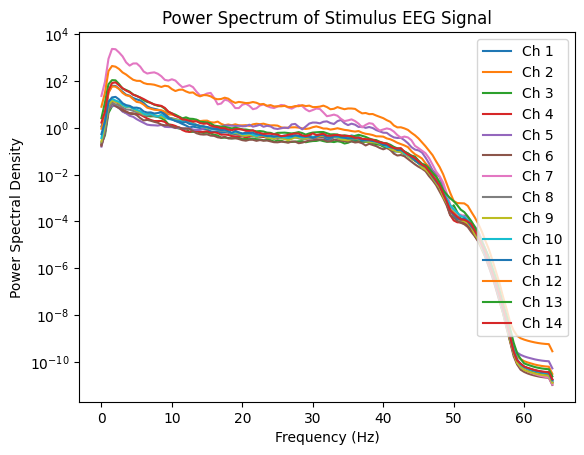

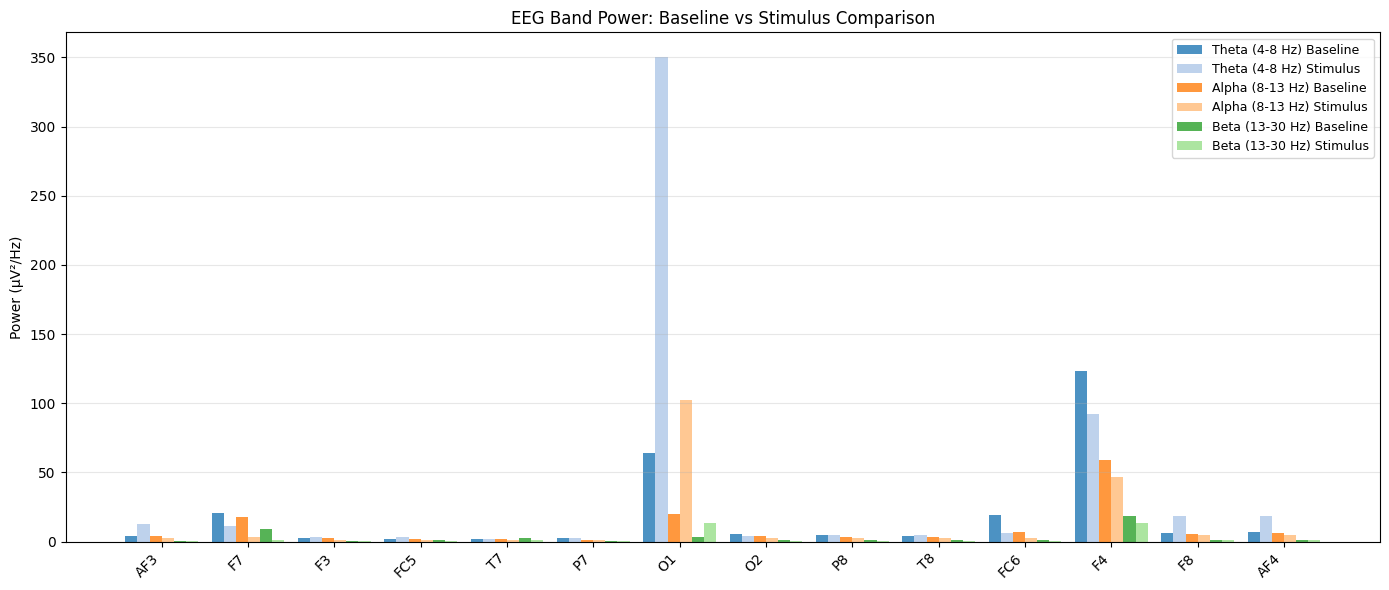

In [22]:
from scipy.signal import welch

# Power Spectrum for Stimulus
f_s , Pxx_s = welch(s , fs=FS , nperseg=FS*2 , axis=0)

theta_s = Pxx_s[(f_s>=4)&(f_s<=8)].mean(axis=0)
alpha_s = Pxx_s[(f_s>=8)&(f_s<=13)].mean(axis=0)
beta_s  = Pxx_s[(f_s>=13)&(f_s<=30)].mean(axis=0)


plt.semilogy(f_s , Pxx_s)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.title("Power Spectrum of Stimulus EEG Signal")
plt.legend([f"Ch {i+1}" for i in range(s.shape[1])])
plt.show()

# Power Spectrum for Baseline
f_b , Pxx_b = welch(b , fs=FS , nperseg=FS*2 , axis=0)
theta_b = Pxx_b[(f_b>=4)&(f_b<=8)].mean(axis=0)
alpha_b = Pxx_b[(f_b>=8)&(f_b<=13)].mean(axis=0)
beta_b  = Pxx_b[(f_b>=13)&(f_b<=30)].mean(axis=0)

# Define channel names for plotting
channels = ["AF3","F7","F3","FC5","T7","P7","O1","O2","P8","T8","FC6","F4","F8","AF4"]

# Plot theta, alpha, beta power for comparison
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(channels))
width = 0.14  # Width of each bar

# Position bars side-by-side for each channel
ax.bar(x - 2.5*width, theta_b, width, label='Theta (4-8 Hz) Baseline', color='#1f77b4', alpha=0.8)
ax.bar(x - 1.5*width, theta_s, width, label='Theta (4-8 Hz) Stimulus', color='#aec7e8', alpha=0.8)
ax.bar(x - 0.5*width, alpha_b, width, label='Alpha (8-13 Hz) Baseline', color='#ff7f0e', alpha=0.8)
ax.bar(x + 0.5*width, alpha_s, width, label='Alpha (8-13 Hz) Stimulus', color='#ffbb78', alpha=0.8)
ax.bar(x + 1.5*width, beta_b, width, label='Beta (13-30 Hz) Baseline', color='#2ca02c', alpha=0.8)
ax.bar(x + 2.5*width, beta_s, width, label='Beta (13-30 Hz) Stimulus', color='#98df8a', alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(channels, rotation=45, ha='right')
ax.set_ylabel("Power (μV²/Hz)")
ax.set_title("EEG Band Power: Baseline vs Stimulus Comparison")
ax.legend(loc='upper right', fontsize=9)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [18]:
#Calculation of band power differences
delta_theta = theta_s - theta_b
delta_alpha = alpha_s - alpha_b
delta_beta  = beta_s  - beta_b



# Calculation Of FAA -> Front Alpha Symmetry 

Alpha power is inverse of brain activation 
We have :

Left frontal -> AF3 , F7 , F3
this frontal is more associated with -> Approach emotions like Happiness , Motivation , Excitement

Right frontal -> AF4 , F8 , F4 
this frontal is more associated with ->  Withdrawl emotions like Fear , Sadness , Anxiety 

we use them to understand the activation of each brain frontal


In [19]:
left_b = alpha_b[[0,1,2]].mean()
right_b = alpha_b[[13,12,11]].mean()
FAA_b = np.log(right_b + 1e-10) - np.log(left_b + 1e-10)

left_s = alpha_s[[0,1,2]].mean()
right_s = alpha_s[[13,12,11]].mean()
FAA_s = np.log(right_s + 1e-10) - np.log(left_s + 1e-10)

d_FAA = FAA_s - FAA_b
print("ΔFAA:", d_FAA)

ΔFAA: 0.036905976750556846


# ΔCorr (Correlation Reactivity)

**What is it?**
The change in synchronization between two frontal brain regions when the video starts.

**Why do we use it?**
It shows how the stimulus affects functional connectivity—whether the brain becomes more coordinated or more disrupted during emotional processing.

**Which channels?**

F3–F4 → mid-frontal circuit (emotion regulation, cognitive control)

F7–F8 → lateral frontal circuit (social-emotional processing)

**How to interpret it?**

ΔCorr > 0 → stronger synchronization → higher engagement

ΔCorr < 0 → reduced synchronization → disengagement or emotional conflict

ΔCorr ≈ 0 → minimal change

In [20]:
corr_b_34 = np.corrcoef(b[:,2], b[:,11])[0,1]
corr_s_34 = np.corrcoef(s[:,2], s[:,11])[0,1]
d_corr_34 = corr_s_34 - corr_b_34

corr_b_78 = np.corrcoef(b[:,1], b[:,12])[0,1]
corr_s_78 = np.corrcoef(s[:,1], s[:,12])[0,1]
d_corr_78 = corr_s_78 - corr_b_78


In [21]:
# Building the DataFrame of Features

#name the channels based on Emotiv Epoc
channel_names = [
    "AF3","F7","F3","FC5","T7","P7","O1",
    "O2","P8","T8","FC6","F4","F8","AF4"
]

all_rows = []

for idx, row in df.iterrows():
    baseline = row["baseline"]
    stimulus = row["stimuli"]

    # Use full baseline and stimulus (no truncation)
    b = baseline
    s = stimulus

    # RMS - compute on original signals (not centered)
    rms_b = np.sqrt(np.mean(b**2, axis=0))
    rms_s = np.sqrt(np.mean(s**2, axis=0))
    d_rms = rms_s - rms_b

    # PSD/BANDS - compute on original signals (not centered)
    f, pxx_b = welch(b, fs=128, nperseg=256, axis=0)
    f, pxx_s = welch(s, fs=128, nperseg=256, axis=0)
    
    theta_b = pxx_b[(f >= 4) & (f <= 8)].mean(axis=0)
    alpha_b = pxx_b[(f >= 8) & (f <= 13)].mean(axis=0)
    beta_b  = pxx_b[(f >= 13) & (f <= 30)].mean(axis=0)
    
    theta_s = pxx_s[(f >= 4) & (f <= 8)].mean(axis=0)
    alpha_s = pxx_s[(f >= 8) & (f <= 13)].mean(axis=0)
    beta_s  = pxx_s[(f >= 13) & (f <= 30)].mean(axis=0)
    
    # FAA Calculation
    left_idx  = [0,1,2]       # AF3, F7, F3
    right_idx = [13,12,11]    # AF4, F8, F4

    left_b  = alpha_b[left_idx].mean()
    right_b = alpha_b[right_idx].mean()
    FAA_b = np.log(right_b + 1e-10) - np.log(left_b + 1e-10)
    
    left_s  = alpha_s[left_idx].mean()
    right_s = alpha_s[right_idx].mean()
    FAA_s = np.log(right_s + 1e-10) - np.log(left_s + 1e-10)
    
    d_FAA = FAA_s - FAA_b
    
    # Correlation Calculation
    corr_b_34 = np.corrcoef(b[:,2], b[:,11])[0,1]  # F3, F4
    corr_s_34 = np.corrcoef(s[:,2], s[:,11])[0,1]
    d_corr_34 = corr_s_34 - corr_b_34
    
    corr_b_78 = np.corrcoef(b[:,1], b[:,12])[0,1]  # F7, F8
    corr_s_78 = np.corrcoef(s[:,1], s[:,12])[0,1]
    d_corr_78 = corr_s_78 - corr_b_78


    feats = {
        "subject_id": row.subject_id,
        "video_id": row.video_id,
        "valence": row.valence,
        "arousal": row.arousal,
        "ΔFAA": d_FAA,
        "ΔCorr_F3F4": d_corr_34,
        "ΔCorr_F7F8": d_corr_78,
    }

    # ΔRMS
    for ch_name, v in zip(channel_names, d_rms):
        feats[f"ΔRMS_{ch_name}"] = v

    # ΔTheta
    for ch_name, v in zip(channel_names, theta_s - theta_b):
        feats[f"ΔTheta_{ch_name}"] = v

    # ΔAlpha
    for ch_name, v in zip(channel_names, alpha_s - alpha_b):
        feats[f"ΔAlpha_{ch_name}"] = v

    # ΔBeta
    for ch_name, v in zip(channel_names, beta_s - beta_b):
        feats[f"ΔBeta_{ch_name}"] = v

    all_rows.append(feats)

features_df = pd.DataFrame(all_rows)
features_df.to_csv("../data/processed/eeg_features_reactivity.csv", index=False)


print(features_df.shape)

(414, 63)
